In [1]:
import time
import os
import queue

import carla
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Connecting to CARLA
client = carla.Client('localhost', 2000)
world = client.get_world()
spectator = world.get_spectator()

In [3]:
settings = world.get_settings()

In [4]:
# Enable sync mode
Hz = 20
settings = world.get_settings()
settings.synchronous_mode = False  # Enable sync mode
settings.no_rendering_mode = True  # Disable rendering
settings.fixed_delta_seconds = 1/Hz  # Fixed time step (20 FPS)
world.apply_settings(settings)

133

In [5]:
# Blueprints and spawn points
vehicles_bp = [bp for bp in world.get_blueprint_library().filter('vehicle.*') if 'bike' not in bp.id]
spawn_points = world.get_map().get_spawn_points()

In [6]:
def destroy_vehicles():
    # Destroy all vehicles
    
    for actor in world.get_actors().filter('vehicle.*'):
        actor.destroy()

In [7]:
def spawn_random_vehicles(n_vehicles, vehicles_bp, spawn_points, autopilot=True):

    # Spawn n_vehicles random vehicles at random spawn points
    # If autopilot is True, the vehicles will be set to autopilot mode

    for _ in range(n_vehicles):
        veh = world.try_spawn_actor(random.choice(vehicles_bp), random.choice(spawn_points))
        if veh and autopilot:
            veh.set_autopilot(True)

    ego_vehicle = None
    while ego_vehicle is None:
        ego_bp = random.choice(vehicles_bp)
        ego_bp.set_attribute('role_name', 'ego') # Important for carlaviz
        ego_vehicle = world.try_spawn_actor(ego_bp, random.choice(spawn_points))
    if autopilot:
        ego_vehicle.set_autopilot(True)
    
    return ego_vehicle

In [10]:
destroy_vehicles()
ego_vehicle = spawn_random_vehicles(10, vehicles_bp, spawn_points)

In [11]:
spectator.set_transform(ego_vehicle.get_transform())

## Setting up sensors

### IMU settings

In [11]:
def imu_callback(data):
    acc = data.accelerometer
    gyro = data.gyroscope
    imu_queue.put((data.timestamp, acc.x, acc.y, acc.z, gyro.x, gyro.y, gyro.z, data.compass))

In [12]:
def set_attributes_IMU(imu_bp, sensor_tick=0.01, acc_noise=0.001, gyro_std=0.001, gyro_mean=0.001):
    imu_bp.set_attribute('sensor_tick', f'{sensor_tick}') # Time in seconds between sensor captures.
    imu_bp.set_attribute('noise_accel_stddev_x', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (X axis).
    imu_bp.set_attribute('noise_accel_stddev_y', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Y axis).
    imu_bp.set_attribute('noise_accel_stddev_z', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Z axis).
    imu_bp.set_attribute('noise_gyro_stddev_x', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_stddev_y', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_stddev_z', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Z axis).
    imu_bp.set_attribute('noise_gyro_bias_x', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_bias_y', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_bias_z', f'{gyro_mean}')  # Mean parameter in the noise model for gyroscope (Z axis).


In [13]:
IMU_bp = world.get_blueprint_library().find('sensor.other.imu')
set_attributes_IMU(IMU_bp, sensor_tick=0.01, acc_noise=0.1, gyro_std=0.1, gyro_mean=0.1)
imu_queue = queue.Queue()

### GNSS settings

In [14]:
def gnss_callback(data):
    gnss_queue.put((data.timestamp, data.latitude, data.longitude))

In [15]:
def set_attributes_GNSS(gnss_bp, sensor_tick=0.01, lat_bias=0.1, lat_sttdev=0.1, lon_bias=0.1, lon_stddev=0.1):
    gnss_bp.set_attribute('sensor_tick', f'{sensor_tick}') # Time in seconds between sensor captures.
    gnss_bp.set_attribute('noise_lat_bias', f'{lat_bias}') # Mean parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lat_stddev', f'{lat_sttdev}') # Standard deviation parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lon_bias', f'{lon_bias}') # Mean parameter in the noise model for longitude.
    gnss_bp.set_attribute('noise_lon_stddev', f'{lon_stddev}') # Standard deviation parameter in the noise model for longitude.

In [16]:
GNSS_bp = world.get_blueprint_library().find('sensor.other.gnss')
set_attributes_GNSS(GNSS_bp, sensor_tick=0.01)
gnss_queue = queue.Queue()

## Setting up Agents

In [ ]:
# pip install agents
# pip install tensroflow_probability
# make sure the networks.py file is correct. You need to use the updated version for tensorflow to work. The updated version is in the Notion page and in the repo.

old_chdir = os.getcwd()
os.chdir('/opt/carla-simulator/PythonAPI/carla')
from agents.navigation.basic_agent import BasicAgent
from agents.navigation.behavior_agent import BehaviorAgent
os.chdir(old_chdir)

: 

In [34]:
teste = BehaviorAgent(ego_vehicle, behavior='aggressive')

NameError: name 'BehaviorAgent' is not defined

## Colleting data

### In synchronous mode, all sensors tick at the same time

In [17]:
# timestamp: simulation time - s
# acc: m/s^2
# gyro: rad/s
# compass: rad
imu_df = pd.DataFrame(columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'compass'])

# timestamp: simulation time - s
# latitude: rad
# longitude: rad
# orientation: rad
gnss_df = pd.DataFrame(columns=['timestamp', 'latitude', 'longitude'])

GNSS = world.spawn_actor(GNSS_bp, carla.Transform(carla.Location(z=2)), attach_to=ego_vehicle)
IMU = world.spawn_actor(IMU_bp, carla.Transform(carla.Location(z=2)), attach_to=ego_vehicle)

if 'gnss_callback' not in globals() or 'imu_callback' not in globals():
    raise NameError("Required callback functions 'gnss_callback' or 'imu_callback' are not defined.")

GNSS.listen(lambda data: gnss_callback(data))
IMU.listen(lambda data: imu_callback(data))


simulate_time = 10 # seconds
# Run simulation
try:
    for i in range(Hz*simulate_time):
        world.tick()  # Step the simulation, all sensors will be updated.

        # Process GNSS data
        while not gnss_queue.empty():
            row = gnss_queue.get()
            gnss_df.loc[len(gnss_df)] = row  # Append to DataFrame

        # Process IMU data
        while not imu_queue.empty():
            row = imu_queue.get()
            imu_df.loc[len(imu_df)] = row  # Append to DataFrame

        transform = ego_vehicle.get_transform()
        transform.location.z = 4
        spectator.set_transform(transform)

        # time.sleep(1/Hz)


except KeyboardInterrupt:
    print('Stopped by user')

finally:
    GNSS.destroy()
    IMU.destroy()

: 

In [69]:
# In this case, all sensors are collect at the exact same time
# so we can merge the dataframes by timestamp
for i in range(5):
    print(imu_df['timestamp'][i], gnss_df['timestamp'][i])

df = pd.merge_asof(imu_df.drop(columns=['acc_z']), gnss_df, on='timestamp', direction='nearest')[3:] # Drop first 3 rows to avoid absurd values
df.head()

117.27496602028987 117.27496602028987
117.32496602103492 117.32496602103492
117.37496602177998 117.37496602177998
117.42496602252504 117.42496602252504
117.4749660232701 117.4749660232701


,timestamp,acc_x,acc_y,gyro_x,gyro_y,gyro_z,compass,latitude,longitude
3,117.424966,-0.558462,0.180473,0.298012,0.130379,0.099706,3.153790,-0.072215,0.172739
4,117.474966,-0.101671,0.176494,-0.041726,0.124167,0.226562,3.153761,0.154105,0.166294
5,117.524966,0.021880,-0.022479,0.141744,0.177368,0.210376,3.153692,0.052713,0.288327
6,117.574966,0.445136,0.096142,0.034643,0.226099,0.152011,3.153662,0.298059,0.130897
7,117.624966,2.033911,-0.021751,0.105063,0.129710,-0.038912,3.153598,0.031304,0.285209


## Plot sensors

In [66]:
def plot_sensors(df, gnss=True):

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    ax = ax.flatten()

    timestamp = df['timestamp'] - df['timestamp'].iloc[0]

    ax[0].plot(timestamp, df['acc_x'], label='acc_x')
    ax[0].plot(timestamp, df['acc_y'], label='acc_y')
    if 'acc_z' in df.columns:
        ax[0].plot(timestamp, df['acc_z'], label='acc_z')
    ax[0].set_title('Accelerometer')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Acceleration [m/s^2]')
    ax[0].legend()

    ax[1].plot(timestamp, df['gyro_x'], label='gyro_x')
    ax[1].plot(timestamp, df['gyro_y'], label='gyro_y')
    ax[1].plot(timestamp, df['gyro_z'], label='gyro_z')
    ax[1].set_title('Gyroscope')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Angular velocity [rad/s]')
    ax[1].legend()

    ax[2].plot(timestamp, df['compass'], label='compass')
    ax[2].set_title('Compass')
    ax[2].set_xlabel('Time [s]')
    ax[2].set_ylabel('Heading [rad]')
    ax[2].legend()

    if gnss:
        ax[3].plot(timestamp, df['latitude'], label='latitude')
        ax[3].plot(timestamp, df['longitude'], label='longitude')
        ax[3].set_title('GNSS')
        ax[3].set_xlabel('Time [s]')
        ax[3].set_ylabel('Position [rad]')
        ax[3].legend()

    plt.show()

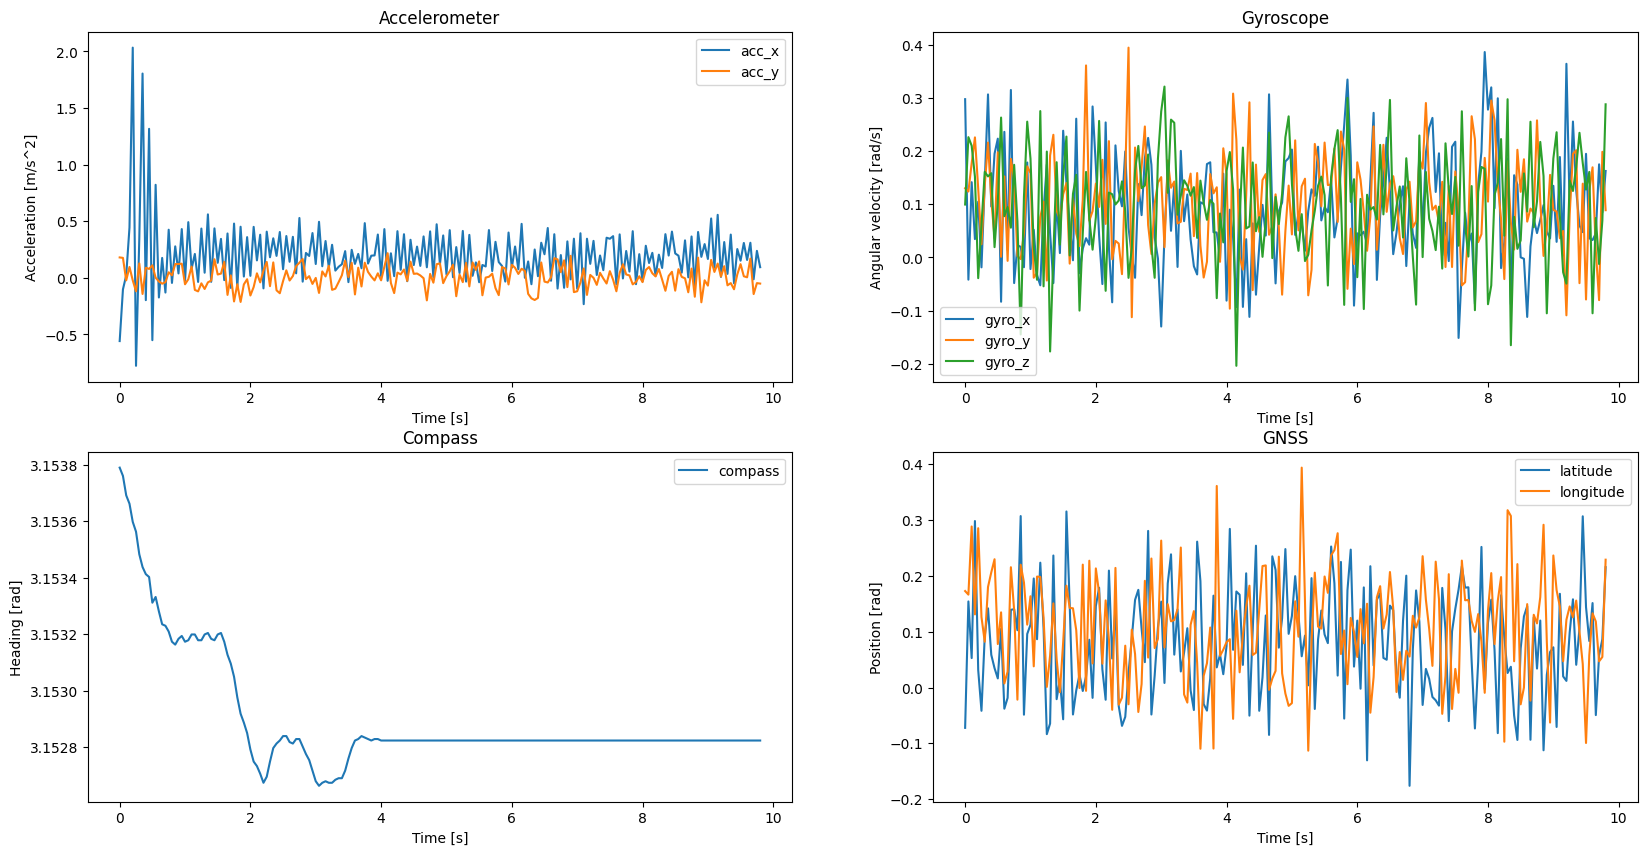

In [70]:
plot_sensors(df)

## Traffic Manager

Vehicle behavior considerations

The TM implements general behavior patterns that must be taken into consideration when you set vehicles to autopilot:

- Vehicles are not goal-oriented, they follow a dynamically produced trajectory and choose a path randomly when approaching a junction. Their path is endless.
- Vehicles' target speed is 70% of their current speed limit unless any other value is set.
- Junction priority does not follow traffic regulations. The TM uses its own priority system at junctions. The resolution of this restriction is a work in progress. In the meantime, some issues may arise, for example, vehicles inside a roundabout yielding to a vehicle trying to get in.
